# Importing Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
from sklearn import preprocessing
import re
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
import matplotlib.cm as cm
from matplotlib import rcParams
%matplotlib inline
from gensim.models import ldamodel
import nltk
from nltk.tokenize import RegexpTokenizer
import gensim.corpora;
from sklearn.preprocessing import normalize
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

# 20 news datasets

    comp.graphics
    comp.os.ms-windows.misc
    comp.sys.ibm.pc.hardware
    comp.sys.mac.hardware
    comp.windows.x    
    rec.autos
    rec.motorcycles
    rec.sport.baseball
    rec.sport.hockey    
    sci.crypt
    sci.electronics
    sci.med
    sci.space
    misc.forsale    
    talk.politics.misc
    talk.politics.guns
    talk.politics.mideast    
    talk.religion.misc
    alt.atheism
    soc.religion.christian

# Loading 20 news dataset

In [36]:
from sklearn.datasets import fetch_20newsgroups
remove=('headers', 'footers', 'quotes')
texts = fetch_20newsgroups(subset='all', remove=remove).data

# Saving the 20 news data in the dataframe

In [37]:
data=pd.DataFrame(texts)

# Giving header as News_text

In [38]:
data=data.rename(columns={0:'News_text'})

# Data Analysis, Preprocessing and Cleaning

### Lenght of data

In [39]:
len(data)

18846

### News text in lower case

In [40]:
data['News_text']=data['News_text'].str.lower()

In [41]:
data['News_text'].head()

0    \n\ni am sure some bashers of pens fans are pr...
1    my brother is in the market for a high-perform...
2    \n\n\n\n\tfinally you said what you dream abou...
3    \nthink!\n\nit's the scsi card doing the dma t...
4    1)    i have an old jasmine drive which i cann...
Name: News_text, dtype: object

### all columns

In [42]:
data.columns

Index(['News_text'], dtype='object')

### data types of all columns

In [43]:
data.dtypes

News_text    object
dtype: object

### Checking Null values

In [44]:
data[data.isnull().any(axis=1)]

,News_text


### Count of Null values

In [45]:
np.sum(data.isnull().any(axis=1))

0

### Data information

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 1 columns):
News_text    18846 non-null object
dtypes: object(1)
memory usage: 147.4+ KB


# Remving the numbers from the news text

In [47]:
for letter in '1234567890.(/':
    data['News_text']= data['News_text'].str.replace(letter,'')

# Remving the single letters (like, "u", "w" etc) from the text

In [48]:
data['News_text']=data['News_text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

### Getting Tokenization of News

In [49]:
tokenizer = RegexpTokenizer(r'\w+')
data['News_text'] = data['News_text'].apply(tokenizer.tokenize)

In [50]:
data['News_text'].head()

0    [am, sure, some, bashers, of, pens, fans, are,...
1    [my, brother, is, in, the, market, for, high, ...
2    [finally, you, said, what, you, dream, about, ...
3    [think, it, the, scsi, card, doing, the, dma, ...
4    [have, an, old, jasmine, drive, which, cannot,...
Name: News_text, dtype: object

### Stop words of english

In [51]:
stopwords_list = stopwords.words('english')

In [52]:
len(stopwords_list)

179

### Removing Stops words from reviews

In [53]:
data['News_text']=data['News_text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [54]:
data['News_text'].head()

0    [sure, bashers, pens, fans, pretty, confused, ...
1    [brother, market, high, performance, video, ca...
2    [finally, said, dream, mediterranean, new, are...
3    [think, scsi, card, dma, transfers, disks, scs...
4    [old, jasmine, drive, cannot, use, new, system...
Name: News_text, dtype: object

### Description of news text information

In [55]:
all_words = [word for tokens in data['News_text'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data['News_text']]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1904041 words total, with a vocabulary size of 116204
Max sentence length is 16291


### Top 20 words in News text

In [56]:
counter = Counter(all_words)

In [57]:
counter.most_common(20)

[('ax', 62471),
 ('one', 10385),
 ('would', 10185),
 ('like', 6505),
 ('people', 6446),
 ('get', 5826),
 ('know', 5756),
 ('also', 5585),
 ('use', 5015),
 ('think', 4989),
 ('time', 4831),
 ('max', 4653),
 ('could', 4174),
 ('us', 4097),
 ('new', 4066),
 ('well', 4055),
 ('may', 4031),
 ('good', 3897),
 ('even', 3794),
 ('see', 3623)]

In [58]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

<BarContainer object of 25 artists>

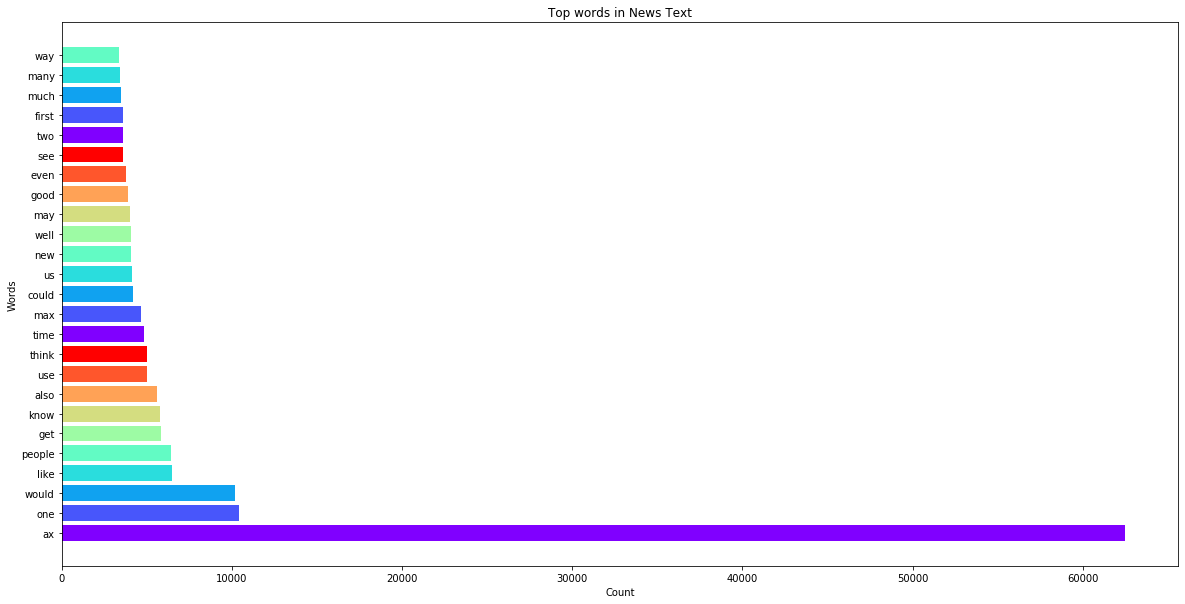

In [59]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in News Text')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

### Word cloud of News Text

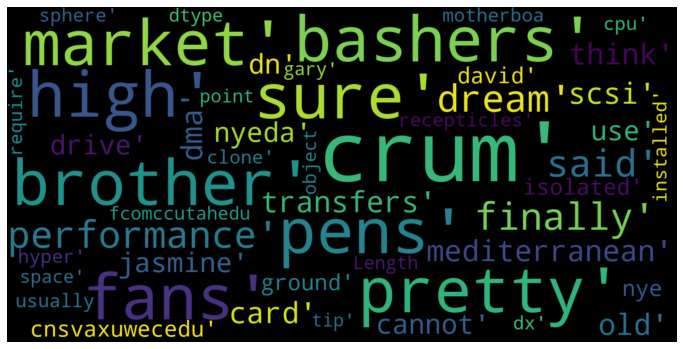

In [60]:
neg =data['News_text']
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).map(str)
neg_string=str(neg_string)


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Function to get the topics using LDA model

In [61]:
def LDA_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Words of Topic ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

# Getting the news text in data_text

In [110]:
data_text=pd.DataFrame(data['News_text'])

# Rename the News_text to News_Text

In [111]:
data_text=data_text.rename(columns={'News_text':'News_Text'})

# Creating for training on LDA model with three topics

In [112]:
train_ = [value[0] for value in data_text.iloc[0:].values]

# Selecting the number of topics

In [113]:
num_topics = 20

# getting dictionary of the text using gensim

In [114]:
id2word1 = gensim.corpora.Dictionary(train_)

# getting the word vector

In [115]:
corpus1 = [id2word1.doc2bow(text) for text in train_]

# Calling the LDA model and feeding the calculated text, dictionary and topics

In [116]:
lda2vec = ldamodel.LdaModel(corpus=corpus1, id2word=id2word1, num_topics=num_topics)

# Calling LDA_topics function and using lda2vec with selective topics

In [117]:
LDA_topics(lda2vec, num_topics)

,Words of Topic 01,Words of Topic 02,Words of Topic 03,Words of Topic 04,Words of Topic 05,Words of Topic 06,Words of Topic 07,Words of Topic 08,Words of Topic 09,Words of Topic 10,Words of Topic 11,Words of Topic 12,Words of Topic 13,Words of Topic 14,Words of Topic 15,Words of Topic 16,Words of Topic 17,Words of Topic 18,Words of Topic 19,Words of Topic 20
0,medical,ripem,game,one,image,captain,windows,get,use,said,god,armenian,gk,ax,people,st,people,aids,people,scsi
1,health,would,team,god,images,norway,file,like,one,fbi,church,turkish,int,max,would,new,would,ra,one,det
2,drug,key,games,would,color,germany,program,one,would,one,christian,armenians,dn,bf,one,book,gun,would,would,bos
3,patients,space,year,know,bit,switzerland,use,would,dos,children,bible,turkey,wc,gv,government,man,right,one,even,pit
4,disease,public,season,think,jpeg,canada,available,new,drive,fire,believe,turks,fc,pl,us,books,one,cancer,men,tor
5,treatment,rsa,hockey,time,gif,france,mail,good,system,people,religion,greece,nh,di,also,art,us,think,like,la
6,bh,pgp,league,jesus,format,ea,information,car,card,would,christians,university,defenseman,mk,think,cover,law,like,go,min
7,patient,psalms,kinsey,like,spacecraft,sweden,software,also,key,koresh,people,genocide,es,tm,many,appears,like,tcpip,sexual,chi
8,newsletter,use,play,things,files,usa,please,time,get,killed,belief,history,ne,mp,state,edition,know,also,think,cal
9,medicine,one,first,say,file,finland,data,well,know,batf,christ,armenia,sm,wm,new,one,think,see,know,van


# Computing the Topic Coherence with 20 

In [120]:
coherence_using_lda2vec = CoherenceModel(model=lda2vec, texts=train_, dictionary=id2word1, coherence='c_v')
coherence = coherence_using_lda2vec.get_coherence()
print('Coherence Score: ', round(coherence, 3))

Coherence Score:  0.626


# pyLDAvis for the output of topics

In [36]:
vis = pyLDAvis.gensim.prepare(topic_model=lda2vec, 
                              corpus=corpus1, 
                              dictionary=id2word1)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)